In [1]:
using DiffEqJump, StochasticDiffEq, DiffEqCallbacks
using StatsBase, Parameters, Plots, Distributions

In [2]:
# functional parameters 
function affect!(integrator) # jump process
      n = rand(1:integrator.p.N)
      n2 = rand(1:integrator.p.N)
      integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end
function drift(du,u,p,t) # constant drift
      du .= p.μ
end
function volatility(du,u,p,t) # constant shock exposure
      du .= p.σ
end
rate(u,p,t) = p.β*p.N # jump rate


# main params bundle
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:4000., # time steps to save
    moments = Array{Array{Float64, 1}, 1}(), # container for moments
    α = 2.0, # shape parameter for the initial condition distribution
    iv_dist = Exponential(1/α), # updates based on supplied α
    trajectories = 2, # number of members for ensemble methods 
    jump_algorithm = SRIW1(), # jump diffeq algorithm
    drift = drift, 
    volatility = volatility, 
    affect! = affect!, # jump process 
    rate = rate)

#3 (generic function with 2 methods)

In [3]:
function generate_jump_prob(p)
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    @show x_iv
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jump = ConstantRateJump(rate, p.affect!)
    jump_prob = JumpProblem(sde_prob, Direct(), jump)
    return jump_prob, cb
end

p = params();

### First Run

In [4]:
jump_prob, cb = generate_jump_prob(p)
sol = solve(jump_prob, p.jump_algorithm, saveat = p.t, callback = cb)
gs_raw = [timepoint[4] for timepoint in p.moments]
gs = gs_raw[400:end] # drop the first 10% for initial condition dependence
summarystats(gs)

x_iv = [0.202856, 1.01487, 0.00484918, 0.894077, 0.156345, 0.009916, 1.28578, 1.54978, 0.0733432, 0.259383]


Summary Stats:
Length:         399602
Missing Count:  0
Mean:           0.048498
Minimum:        -1.146746
1st Quartile:   -0.056454
Median:         0.009993
3rd Quartile:   0.078340
Maximum:        26.211265


For the histogram, let's eliminate "outliers."

# of observations dropped: 2905


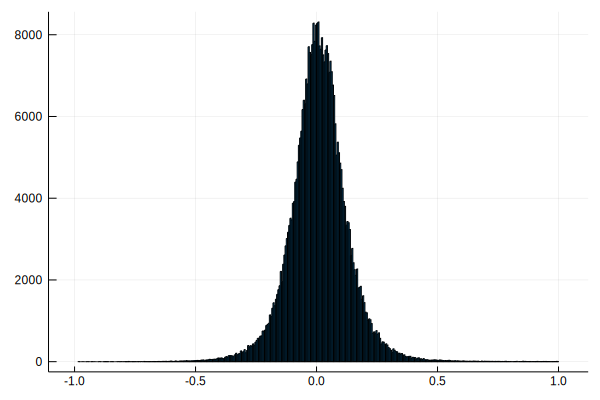

In [5]:
gs_clamped = filter(x -> x < 1 && x > -1, gs)
println("# of observations dropped: $(length(gs) - length(gs_clamped))") # distributions dropped
histogram(gs_clamped, legend = false)

### Second Run, New Initial Condition Draw

In [6]:
p = params(); # new p for fresh moments cache
jump_prob, cb = generate_jump_prob(p)
sol = solve(jump_prob, p.jump_algorithm, saveat = p.t, callback = cb)
gs_raw = [timepoint[4] for timepoint in p.moments]
gs = gs_raw[400:end] # drop the first 10% for initial condition dependence
summarystats(gs)

x_iv = [0.624904, 0.648328, 0.292983, 0.563282, 0.0238462, 0.13871, 0.237603, 1.4242, 0.77625, 0.512467]


Summary Stats:
Length:         399602
Missing Count:  0
Mean:           0.046874
Minimum:        -1.085170
1st Quartile:   -0.058006
Median:         0.009600
3rd Quartile:   0.079121
Maximum:        30.794930


# of observations dropped: 2969


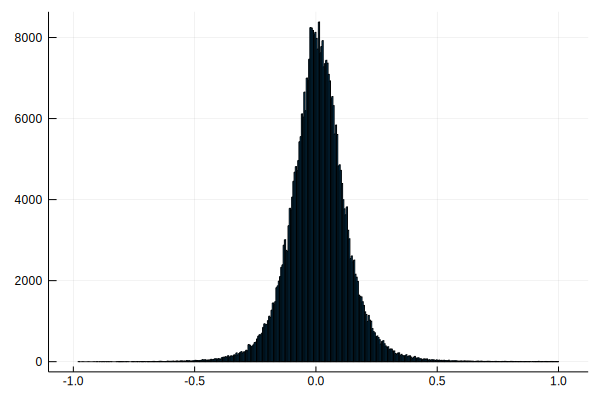

In [7]:
gs_clamped = filter(x -> x < 1 && x > -1, gs)
println("# of observations dropped: $(length(gs) - length(gs_clamped))") # distributions dropped
histogram(gs_clamped, legend = false)

### Space Average across Ensemble

In [8]:
function generate_jump_prob_nocallback(p)
    x_iv = rand(p.iv_dist, p.N) # draw initial condition
    sde_prob = SDEProblem(p.drift, p.volatility, x_iv, (0.0, p.t[end]), p)
    jump = ConstantRateJump(rate, p.affect!)
    jump_prob = JumpProblem(sde_prob, Direct(), jump)
    return jump_prob
end

function generate_ensemble_prob(p)
    prob = generate_jump_prob_nocallback(p);
    function write_moments(sol, i) 
        resize!(sol.t, 0); resize!(sol.u, 0); append!(sol.t, sol.prob.p.t); append!(sol.u, sol.prob.p.moments)
        return (sol, false)
    end
    function calculate_moments(u, t, integrator) 
        g = (length(integrator.p.moments) == 0. ? 0. : (mean(u) - integrator.p.moments[end][2])/step(integrator.p.t))
        moments = [minimum(u), mean(u), maximum(u), g]
        push!(integrator.p.moments, moments) 
    end
    cb = FunctionCallingCallback(calculate_moments; funcat=p.t, func_everystep=false, func_start = true, tdir=1);
    ensemble_prob = EnsembleProblem(prob, output_func = write_moments)    
    return ensemble_prob, cb
end

p = params(trajectories = 40000, t = 0:0.01:10.); 

In [9]:
ensemble_prob, cb = generate_ensemble_prob(p)
sim = solve(ensemble_prob, p.jump_algorithm, EnsembleDistributed(), trajectories = p.trajectories, callback = cb, save_everystep = false);

In [10]:
gs = [sim.u[x].u[500][4] for x in 1:p.trajectories] # g at 500th t-val across trajectories
summarystats(gs)

Summary Stats:
Length:         40000
Missing Count:  0
Mean:           0.068479
Minimum:        -0.786582
1st Quartile:   -0.056770
Median:         0.011612
3rd Quartile:   0.080748
Maximum:        19.890605


# of observations dropped: 319


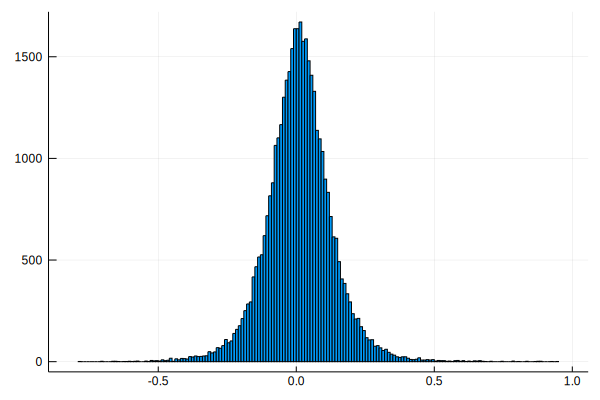

In [11]:
gs_clamped = filter(x -> x < 1 && x > -1, gs)
println("# of observations dropped: $(length(gs) - length(gs_clamped))") # distributions dropped
histogram(gs_clamped, legend = false)